In [2]:
import pandas as pd
import os

In [3]:
topic = 'abortion'
scheme = 'EIII_v2'

path = os.getcwd()
clean_path = f'{path}/clean'
NN_path = f'{path}/NN/{topic}/{scheme}'

train_file = f'{path}/train/labeled_{topic}_train.csv'
test_file = f'{path}/test/labeled_{topic}_test.csv'

os.makedirs(NN_path, exist_ok=True)
os.makedirs(f'{clean_path}/train', exist_ok=True)
os.makedirs(f'{clean_path}/test', exist_ok=True)

NN_path

'/media/rinnely/Archer1/ENES/Stance/Clasificador/NN/abortion/EIII_v2'

In [4]:
train = pd.read_csv(train_file)

In [ ]:
train.head()

In [5]:
train = train[[f'Label_{scheme}', 'Tweet']]
train.columns = ['Label', 'Tweet']

In [ ]:
train.head()

In [ ]:
train.Label.unique()

In [6]:
train = train.query('Label != 0')
train.Label.unique()

array([ 1, -1])

In [ ]:
train.groupby('Label').count()

In [7]:
test = pd.read_csv(test_file)
test.head()

,Tweet,Target,Stance,Opinion Towards,Sentiment
0,Need a ProLife R.E. Agent? - Support a ProLife...,Legalization of Abortion,AGAINST,2. The tweet does NOT expresses opinion about ...,pos
1,Where is the childcare program @joanburton whi...,Legalization of Abortion,AGAINST,2. The tweet does NOT expresses opinion about ...,neg
2,I get several requests with petitions to save ...,Legalization of Abortion,AGAINST,2. The tweet does NOT expresses opinion about ...,neg
3,"we must always see others as Christ sees us,we...",Legalization of Abortion,AGAINST,2. The tweet does NOT expresses opinion about ...,pos
4,PRAYERS FOR BABIES Urgent prayer one in Lexing...,Legalization of Abortion,AGAINST,2. The tweet does NOT expresses opinion about ...,pos


In [8]:
test = test[['Stance', 'Tweet']]
test.Stance.unique()

array(['AGAINST', 'FAVOR', 'NONE'], dtype=object)

In [9]:
test['Stance']= test.Stance.replace({'FAVOR':1, 'AGAINST':-1, 'NONE':0})
test = test.query('Stance != 0')
test.Stance.unique()

array([-1,  1])

In [10]:
test.columns = ['Label', 'Tweet']
test.groupby('Label').count()

,Tweet
Label,
-1,544
1,167


In [11]:
train.shape, test.shape

((5518, 2), (711, 2))

# clean data

In [14]:
import sys
sys.path.insert(0, '/media/rinnely/Archer1/ENES/Stance')
import cleandata as cd

In [15]:
train = cd.cleanData(train.copy(), label='Tweet', hashtags=True, urls='URL', emojis=True, users='USER')
test = cd.cleanData(test.copy(), label='Tweet', hashtags=True, urls='URL', emojis=True, users='USER')

In [ ]:
train = train.dropna(axis=0)

# save data

In [16]:
train.to_csv(f'{clean_path}/train/clean_{topic}_{scheme}_train.csv', index=False)
test.to_csv(f'{clean_path}/test/clean_{topic}_{scheme}_test.csv', index=False)

# read data

In [17]:
train = pd.read_csv(f'{clean_path}/train/clean_{topic}_{scheme}_train.csv')
test = pd.read_csv(f'{clean_path}/test/clean_{topic}_{scheme}_test.csv')

In [ ]:
train['Label'].value_counts().plot.pie(legend=True)

In [ ]:
test['Label'].value_counts().plot.pie(legend=True)

In [ ]:
train['Label'].value_counts().plot.bar(legend=True)

In [ ]:
test['Label'].value_counts().plot.bar(legend=True)

In [ ]:
train

In [ ]:
train.info()

In [ ]:
test.info()

In [ ]:
train = train.dropna(axis=0)

In [ ]:
train.info()

# Training

In [18]:
from fastai.text import *

In [19]:
data_lm = (TextList.from_df(train, NN_path, cols='Tweet')
          .split_by_rand_pct(0.2)
          .label_for_lm() # this does the tokenization and numericalization
          .databunch())

/home/rinnely/anaconda3/lib/python3.8/site-packages/fastai/core.py:302: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(a, dtype=dtype, **kwargs)


In [ ]:
data_lm.show_batch()

In [20]:
data_clas = TextClasDataBunch.from_df(NN_path, train_df=train, 
                                      valid_df=test, 
                                      vocab=data_lm.vocab, 
                                      text_cols = 'Tweet', 
                                      label_cols = 'Label',
                                      bs=32)

/home/rinnely/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [ ]:
data_clas.show_batch()

In [ ]:
f'data_clas_{topic}_{scheme}'

In [21]:
data_lm.save(f'data_lm_{topic}_{scheme}')
data_clas.save(f'data_clas_{topic}_{scheme}')

In [ ]:
data_lm.train_ds.vocab.itos[:10], len(data_lm.train_ds.vocab.itos)

In [22]:
#learn = ftxt.language_model_learner(data_lm, arch=ftxt.AWD_LSTM, drop_mult=.2)
learn_lm = language_model_learner(data_lm, arch=AWD_LSTM, drop_mult=.5)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.75E-02
Min loss divided by 10: 5.25E-02


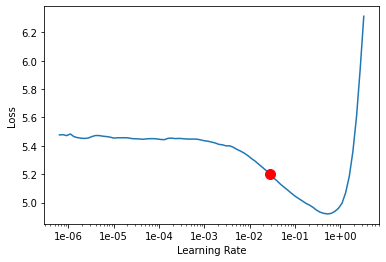

In [23]:
learn_lm.lr_find(); learn_lm.recorder.plot(suggestion=True)

In [24]:
learn_lm.fit_one_cycle(5,2e-2)

epoch,train_loss,valid_loss,accuracy,time
0,4.677762,3.833487,0.271004,00:12
1,4.013134,3.562752,0.301384,00:11
2,3.633491,3.499846,0.309732,00:12
3,3.354303,3.473955,0.315312,00:12
4,3.164296,3.465926,0.315513,00:12


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 7.59E-07
Min loss divided by 10: 3.63E-04


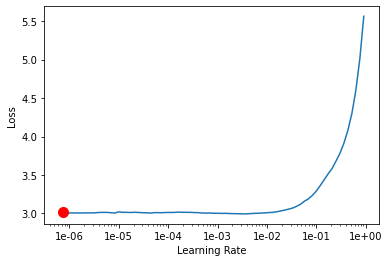

In [25]:
learn_lm.unfreeze()
learn_lm.lr_find(); learn_lm.recorder.plot(suggestion=True)

In [26]:
learn_lm.fit_one_cycle(3)

epoch,train_loss,valid_loss,accuracy,time
0,2.982150,3.431545,0.323549,00:17
1,2.913975,3.407437,0.327902,00:17
2,2.815681,3.416740,0.327478,00:17


In [27]:
learn_lm.save_encoder(f'{topic}_ml_encoder_v1')

In [28]:
learn_lm.load_encoder(f'{topic}_ml_encoder_v1');

In [29]:
learn_lm.save(f'{topic}_model_v1')

In [30]:
learn_lm.load(f'{topic}_model_v1');

In [31]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)

In [32]:
from sklearn.metrics import f1_score

@np_func #converts torch tesnsor as numpy array
def f1_macro(inp, targ): return f1_score(targ, np.argmax(inp, axis=1), average='macro')

In [33]:
learn.load_encoder(f'{topic}_ml_encoder_v1')
learn.metrics=[f1_macro]
learn.freeze()

In [34]:
learn.save('learner-1stage')

In [35]:
learn.load('learner-1stage');

epoch,train_loss,valid_loss,f1_macro,time


/home/rinnely/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.09E-03
Min loss divided by 10: 1.74E-02


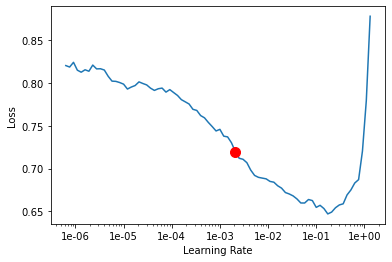

In [36]:
learn.lr_find(); learn.recorder.plot(suggestion=True)

In [37]:
learn.fit_one_cycle(5,2e-3,moms=(0.8, 0.7))

epoch,train_loss,valid_loss,f1_macro,time
0,0.570660,1.164853,0.315080,00:11
1,0.539895,1.032523,0.275897,00:10
2,0.515251,1.121477,0.266719,00:09
3,0.511481,1.108747,0.258429,00:10
4,0.496191,1.167446,0.249977,00:11


/home/rinnely/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/home/rinnely/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 

In [38]:
learn.save('learner-2stage')

In [39]:
learn.load('learner-2stage');

epoch,train_loss,valid_loss,f1_macro,time


/home/rinnely/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 4.79E-06
Min loss divided by 10: 1.74E-04


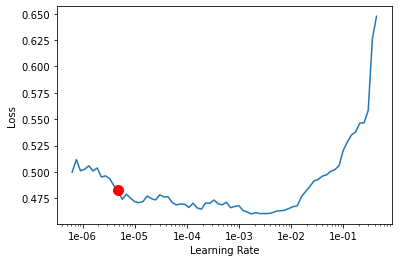

In [40]:
learn.lr_find(); learn.recorder.plot(suggestion=True)

In [41]:
learn.fit_one_cycle(3, 4e-6,moms=(0.8, 0.7))

epoch,train_loss,valid_loss,f1_macro,time
0,0.503174,1.092471,0.259837,00:10
1,0.504985,1.137163,0.255570,00:11
2,0.496891,1.118931,0.266828,00:10


/home/rinnely/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/home/rinnely/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 

In [42]:
learn.save('learner-3stage')

In [43]:
learn.load('learner-3stage');

epoch,train_loss,valid_loss,f1_macro,time


/home/rinnely/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 1.58E-07


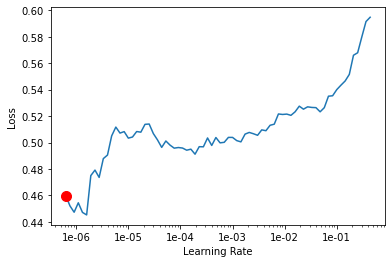

In [44]:
learn.lr_find(); learn.recorder.plot(suggestion=True)

In [ ]:
learn.fit_one_cycle(5, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,f1_macro,time


/home/rinnely/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 1.32E-07


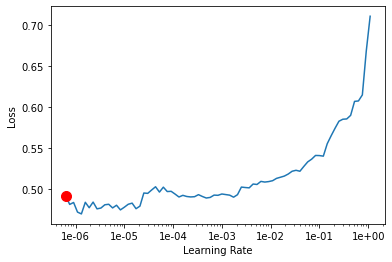

In [45]:
learn.freeze_to(-2)
learn.lr_find(); learn.recorder.plot(suggestion=True)

In [46]:
learn.fit_one_cycle(5,6e-7,moms=(0.8, 0.7));

epoch,train_loss,valid_loss,f1_macro,time
0,0.507562,1.107101,0.267195,00:13
1,0.497748,1.199403,0.247752,00:14
2,0.500853,1.132666,0.259768,00:13
3,0.499761,1.158090,0.252493,00:13
4,0.491787,1.199755,0.252387,00:12


/home/rinnely/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/home/rinnely/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 

In [47]:
learn.save('learner-stage-freeze-2')

In [48]:
learn.save('learner-stage-freeze-2')

epoch,train_loss,valid_loss,f1_macro,time


/home/rinnely/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 1.10E-07


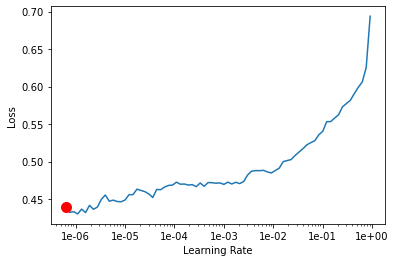

In [49]:
learn.freeze_to(-3)
learn.lr_find(); learn.recorder.plot(suggestion=True)

In [50]:
learn.fit_one_cycle(3, 6e-7, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,f1_macro,time
0,0.481280,1.122787,0.268726,00:19
1,0.494480,1.102353,0.260821,00:22
2,0.471488,1.140629,0.253773,00:20


/home/rinnely/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/home/rinnely/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 

In [ ]:
learn.save('learner-stage-freeze-3')

In [ ]:
learn.load('learner-stage-freeze-3');

In [ ]:
learn.unfreeze()
learn.lr_find(); learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(3, moms=(0.8, 0.7))

In [ ]:
data = pd.read_csv(train_file)
data.head()
data['NNAgainst'] = ''
data['NNFavor'] = ''
data.head()
data = cd.cleanData(data.copy(), label='Tweet', hashtags=True, urls='URL', emojis=True, users='USER')
data.head()

In [ ]:
from tqdm.notebook import tqdm, trange
import time 
for i in trange(data.shape[0]):
    #time.sleep(0.01)
    data.loc[i,'Tweet']
    result = learn.predict(data.loc[i,'Tweet'])
    r = result[2].numpy()
    data.loc[i,'NNAgainst'] = r[0]
    data.loc[i,'NNFavor'] = r[1]

In [ ]:
data['NNPred'] = data[['NNFavor','NNAgainst']].apply(lambda x : 1 if x[0] >= 0.70 else( -1 if x[1] >= 0.70 else 0 ),axis=1)

In [ ]:
data

In [ ]:
data.to_csv('/media/rinnely/Archer/ENES/Stance/Clasificador/train/labeled_atheism_NNtrain.csv', index=False)

In [ ]:
learn.save('learner-stage-unfreeze-62')

In [ ]:
learn.load('learner-stage-unfreeze-62');

In [ ]:
preds, y, losses = learn.get_preds(with_loss=True)
interp = TextClassificationInterpretation(learn, preds, y, losses)

In [ ]:
interp.plot_confusion_matrix()

In [ ]:
preds

In [ ]:
learn.save('learner-final')